## 代码功能：  
### 1.读取自己实现的MyDeepLab与开源实现的DeepLab两个模型，并加载同一个模型参数文件，使用同样输入进行推理结果对比分析，验证实现是否正确  
### 2.将预测结果进行展示

In [1]:
# 导入自己的模型文件
from MyDeepLab import *

# 导入github的模型文件
from modeling.deeplab import *

## 加载模型参数

In [3]:
state_dict = torch.load('deeplab-mobilenet.pth.tar', map_location=torch.device('cpu'))

## 创建自己代码的模型对象，并加载模型参数

In [5]:
my_model = MyDeepLab(backbone='mobilenet', output_stride=16)
my_model.load_state_dict(state_dict['state_dict'])
my_model.eval()

MyDeepLab(
  (backbone): MyMobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## 创建github开源的模型对象，并加载模型参数

In [6]:
git_model = DeepLab(backbone='mobilenet', output_stride=16, sync_bn=False)
git_model.load_state_dict(state_dict['state_dict'])
git_model.eval()

DeepLab(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## 接口定义

In [7]:
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

def preprocess(img):
    """
    输入图像预处理
    """
    # Normalize
    img = np.array(img).astype(np.float32)
    img /= 255.0
    img -= (0.485, 0.456, 0.406)
    img /= (0.229, 0.224, 0.225)
    img = np.transpose(img, (2,0,1))
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img)
    return img

def postprocess(output):
    """
    后处理：将输出结果转换为类别分割图
    """
    output = output.numpy()
    output = output[0]
    output = np.asarray(np.argmax(output, axis=0), dtype=np.uint8)
    return output

## 读取图像，预处理，推理预测，结果展示

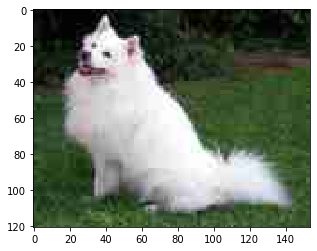

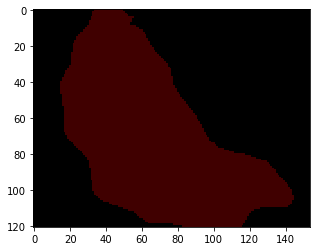

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('dog.jpg').convert('RGB')
plt.figure()
plt.imshow(img)
plt.figure()

my_model.eval()
with torch.no_grad():
    input = preprocess(img)
    output = my_model(input)
    output = postprocess(output)
    mask_img = Image.fromarray(output)
    mask_img.putpalette(get_palette(21))
    plt.imshow(mask_img)

# 验证自己模型代码与github代码预测结果一致性

In [12]:
input = torch.rand(1, 3, 512, 512)

## 模型推理结果对比

In [13]:
my_output = my_model(input)
git_output = git_model(input)

isEqual = torch.equal(my_output, git_output)
print("两种实现结果是否一致:{}".format(isEqual))

两种实现结果是否一致:True
